# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data['income'].head(n=1))



0    <=50K
Name: income, dtype: object

### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == ">50K"])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == "<=50K"])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k)/(n_greater_50k+n_at_most_50k)*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

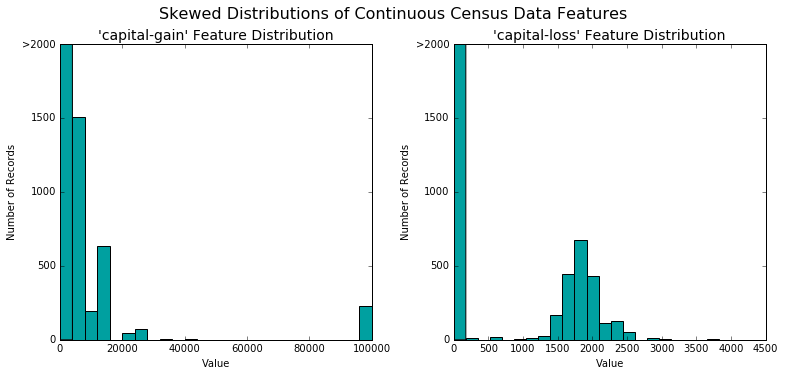

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)


For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

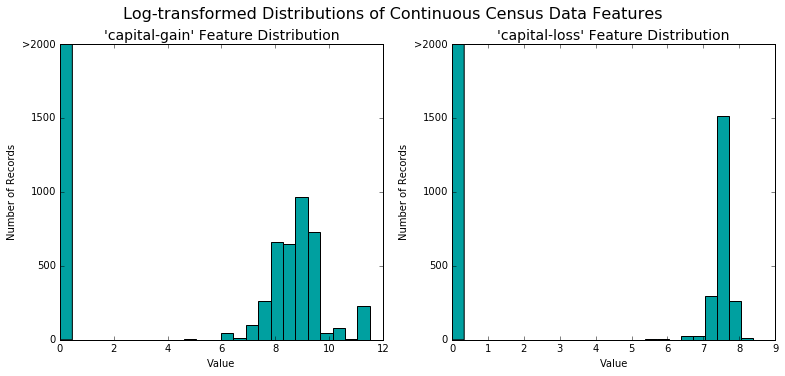

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
from pandas import get_dummies
features = get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map(lambda x: 0 if x == "<=50K" else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded


103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

In [8]:
# TODO: Calculate accuracy
accuracy = float(n_greater_50k)/n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
beta_sq = 0.5*0.5
percision = float(n_greater_50k)/(n_records)
recall = 1.00
fscore = (1+beta_sq)*((percision*recall)/(beta_sq*percision+recall))
# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application

List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

I have chosen the following three models to test on the census data:

1) Ensemble AdaBoost using default decision tree as the base estimator.

One possible application of the boosting algorithim in the healthcare industry is to accurately segment damaged tissue from healthy tissue within a medical image. The paper cited below by Akinobu describes using boosting to extract liver lesions from CT images. The data had many features (54 used, some computed while others directly from the images). Lesions tend to be vary alot in shape, and so generalizability tends to become an issue. A boosting approach tackles the variance in this problem by combining numerous weak models on a set of training images. As the number of iterations of training increased the more "difficult" aspects of each lesion were able to be captured with more confidence (Due to the nature of boosting itself). This generalizability can be seen in the similar training and test Jaccard Indexes (performance metric in this study). In addition using an ensemble approach would better incorporate the variannces in predictions a single particular learner could produce. This is even more important in this study since data is limited to a small sample size (<20 images). 

In general boosting has the advantage of having better performance as the number of iterations of weak learner creation is increased. This will give the outputted model a higher confidence in its predicitons without contribuuting too overfitting. Training can be efficient since you can choose the number of weak learners you want to incorporate, and weak learners may be simple due to only needing to achieve an error rate of <.5. Ensemble methods in general can preform well in comparison to some non-ensemble models when data is not linearly separabl data since it can capture complexity by the combination of many weak learners.

Boosting can have the disadvantage of becoming not as easy to interpret since the model can become fairly complex. Unlike a graphical representation of a single decision tree there isn't always a clear way to visualize the way the final model maps inputs to outputs. Boosting can preform badly if the base learner originally overfits to the data with low error, subsequent weak learners may also overfit since there may not be much change to the model, and thus the final model would also overfit to the data.

For the CharityML finding donors problem boosting may be a good candidate to solve this problem because there are many (103) features to the data, and this may very well mean the data is not linearly separable. Since the dataset is large, there is a high chance that there is a hypothesis that could be classified as weak for any distribution of the data. I think using a decision tree as the base learner may work well since they tend to make the best splits at the beginning and thus a weak learner may only need to ask one question to satisfy its error conditon. In this way it could speed up trianing time. 

References

Shimizu, Akinobu, et al. "Ensemble segmentation using AdaBoost with application to liver lesion extraction from a CT volume." Proc. MICCAI Workshop on 3D Segmentation in the Clinic: A Grand Challenge II., NY, USA. 2008.

Udacity/Georgia Tech Machine Learning Course


2) Stochastic Gradient Descent (SGD) Classifier with default hinge loss estimation

The paper by Lin describes applying SGD classification for large scale image classification. The authors used a variant of SGD called Averaged Stochastic Gradient Descent (ASGD) to train an SVM model to classify 1.2 million images into 1000 different classes. This was able to be accomplished by training and combining prediction scores of 1000 binary svm models with 6 feature sets (each with around or above 100,000 dimmensions). Since the feature space is very complicated an SVM model was deemed appropriate. Conventional learning using the kernel trick was not a viable option because of computational constraints (memory needed, scalability to train the many binary models). ASGD circumvents this by only needing a single sample (or small sample if using a mini-batch approach) for each iteration of gradient/weight calculations. By computing a moving average of the weights they were able to capitalize on the increased speeds possible as described by Bottou. Results of this paper could be used in industry by companies like CamFind who focus on visual search by analyzing user taken photos. Being able to correctly classify an image would be useful to a company like this so it can present users with appropriate search results. The company could then also show a user links to where they can purchase the product that was searched for.

Advantages of SGD include efficiency (as compared to regular gradient descent) since not all of the data has to be taken into account for each iteration of the descent. The algorithm is fairly easy to explain to people. Minimizing error (in whatever form the equation maybe) is a simple concept to understand. SGD in general is also flexible since it can minimize the error functions of many different types of classification models. SGD can also be used for online learning which would be useful in industry where market trends may change over time. Using the soft-hinge loss function of a linear SVM will allow us to gain the advantage of leaning towards a model that generalizes well by maximizing margin. 

Weakness of SGD and gradient descent in general is the possibility of getting stuck in a local minimum. However by randomizing initial parameter values we can hopefully get around this issue. SGD may also be limited if the sample of data it uses to estimate error on invidiual iterations is not a good sample of the actual dataset resulting in poor error estimations. 

Based on the above I believe using an SGDclassifier to optimize a hinge loss (Lienar SVM) function would be a reasonable candidate for the CharityML problem. The large feature space is something SVM are good at dealing with. SGD may be able to compensate for the training time usually needed when training SVM through a kernel and quadratic programming. There is a class imbalance since there are many more people labeled as earning <=50k as compared to those earning >50k. However if we consider that having more than >10,000 examples in each class is enough data to closely represent the actual distribution of data the SVM model should not have a significant negative impact on classification. If there is a low test accuracy this is something that could be compensated for by optimizing class weights. Although the data may not be linearly separable a soft hinge estimation will allow us to be flexible to take into account some crossover of classes over the estimated decision boundary. If the data is very non-linearly separable it will be shown by poor performance of accuracy and F-score, and I can try other models over this one.  


References

Lin, Y., Lv, F., Zhu, S., Yang, M., Cour, T., Yu, K., ... & Huang, T. (2011, June). Large-scale image classification: fast feature extraction and svm training. In Computer Vision and Pattern Recognition (CVPR), 2011 IEEE Conference on (pp. 1689-1696). IEEE.
Udacity Machine Learning Course

Bottou, L.: Stochastic Gradient Descent Tricks. In: Montavon, G., Orr, G.B., Müller, K.-R. (eds.) NN: Tricks of the Trade, 2nd edn. LNCS, vol. 7700, pp. 421–436. Springer, Heidelberg (2012)


3) Logisitc Regression.

One real world use of logistic regression can be to detene if people will default whether or not people will default on a bank loan (binary classification). This was done in a case study by SmartDrill Data Mining. Using predictors like (debt, age, years of employment) they were able to obtain decent training and testing accuracy. Due to using logistic regression they were able to get probability estimates of likelhood of default and use them as a source of model validation. Having the abillity to easily add or remove predictors allowed for the model to be easily optimized. Clearly being an organization like a bank, and being able to predict who would be a good candidate for a loan could potentially save money. Having a simple model with a few predictors would also allow a bank to be transparent to potential clientele about how they determine loan eligibility.

Advantages of Logistic Regression include it being easy to implement since it can be estimated using Iteratively reweighted least squares since the model can be expressed as a variant a typical general linear model (Where the output is classification). This makes it scalabe to large datasets. Logistic Regression gives maximum likelihood probability estimates of the different classes, which can be used in further modeling. These estimates can then be used to classify data.

Disadvantages of Logistic Regression can include over fitting if there are too many features and too few observations. More features results in more complexity, and may lead to over believing the structure of the training data. It seems people have different rules of thumb for the # of observation to the # of featres. Some use the Rule of 10 where there should be 10 observations for each feature. Thus an inadequate sample size may limit generalization of the model. Having a lot of features may also make it difficult to assume that they are all independent of each other, which can also impact probability estimates if there are complex relationships between variables. 

Logistic Regression may be a good candidate for the CharityML problem since it can be easily implemented, deal with our categorical data after encoding, and provide probability estimates for our two classes. Training time will be on the order of n, and so we can easily try different optimizations. If we use the Rule of 10, our dataset may not be big enough since we have 103 features after encoding. However we can tell if performance suffers by scores on a testing set and Cross-Validation. If the data is fairly linearly separable we should get similar performance to the SGD descrbed above, and would be a much simpler way to explain the data. 

References

“ Credit Risk Analysis Using Binary Logistic Regression.” SmartDrill , smartdrill.com/logistic-regression.html.

Comparing SVM and logistic regression. (n.d.). Retrieved August 21, 2017, from https://stats.stackexchange.com/questions/95340/comparing-svm-and-logistic-regression

“Logistic Regression.” USF Faculty Pages, faculty.cas.usf.edu/mbrannick/regression/Logistic.html.

Other References (for all)

Sklearn Documentation

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
        
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

SGDClassifier trained on 362 samples.
SGDClassifier trained on 3618 samples.
SGDClassifier trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.


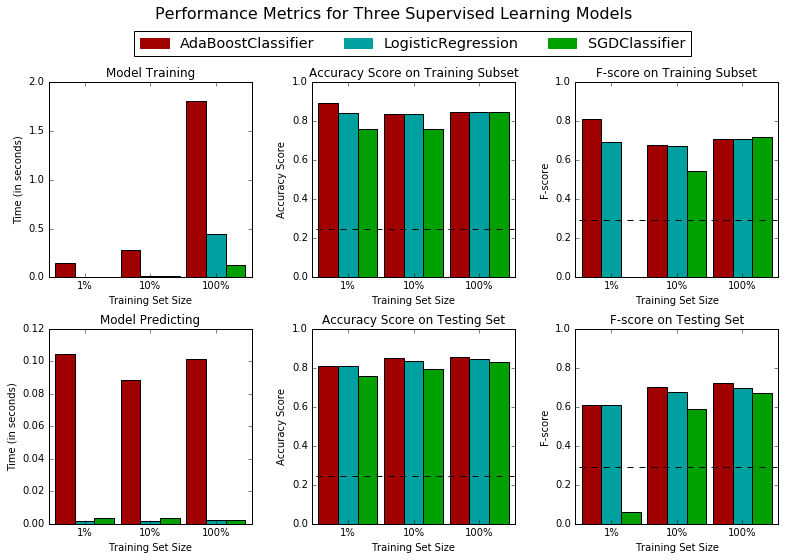

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
# TODO: Initialize the three models
clf_A = SGDClassifier(random_state=10)
clf_B = AdaBoostClassifier(random_state=10)
clf_C = LogisticRegression(random_state=10)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(0.01*len(X_train)))
samples_10 = int(round(0.1*len(X_train)))
samples_100 = int(len(X_train))


# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** I would choose the AdaBoostClassifier model to be the most appropriate. This is due to the model having the best accuracy and F-score on the testing set (>0.8 accuracy score,>0.7 F-score). In addition since the AdaBoost classifier did not show overfitting as the test set size increased, we can be reasonably sure that the initial weak learner was not overfitting the data. This will alow us to take advantage of being able to get better test performance simply by adding more iteratons to the model's estimation (which is characteristic of boosting based on the udacity/georgia tech lectures). Although the model had a much higher train/predict time, I would still use it since accuracy and percision are more important in this situation. Especially since a non-profit may not have the money, and resources to waste on trying to recruit donors that were misclassified. The initial trianing time would thus be worth the value. Like I also mentioned previously since decision trees having the best split at the top can make it easy to find weak learners quickly on each iteration of the algorithm (Which would be hlepful if we increase the number of weak learners for better performance). Furthermore since decision trees can deal with nonlinear data we don't have to make too many assumptions about our data. Linear separability may be a problem since we do have many features, and this may be reflected in the somewhat lower F-Score (~0.65) of the SGD. The Logistic regression may be preforming a little better than the SGD even though the data is not strictly linearly separable due to it being a high bias model.  

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** AdaBoost makes classification predictions by taking a weighted vote of what many simple models think a new datapoint should be labeled as. AdaBoost is trained by building simple models which individually describe the training data with an accuracy of >50%. In the case of when there are only two ways of possibly labeling the data each of these simple models can be thought of as performing predictions better than a coin flip. These basic models are made by iterating the algortihm many times. Along the way we force later iterations to generate simple models that preform better on the example data that was previously misclassified while still meeting the accuracy requirement.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [13]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=10)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators': [1, 10, 50, 100], 'learning_rate': [0.01, 0.1, 1, 10] }

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8606
Final F-score on the testing data: 0.7316


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |             0.2478        |          0.8576         |      0.8606           |
| F-score        |           0.2917          |        0.7246           |      0.7316       |


**Answer: ** The optimized model preforms better than the unoptimized model both in terms of accuracy and F-score. This is a 0.35%, and 0.96% increase respectively. Compared to the naive predictor the optimized increased 247.3% (0.6128 absolute metric increase) and 150.8% (0.4399 absolute metric increase) better in accuracy and F-score respectively. Clearly we are preforming well better than the naive predictor, however absolute performance would still need to be judged to be appropriate by CharityML's staff. The optimized model does only slightly better than the unoptimized model. However slight increases can still mean alot if the number of predictions going to be made will be large. Furthermore only two parameters were optimized which were stated as having a trade off in the sklearn documentation. Even if our initial guess was better, it seems worthwhile to show this is the case through a standard procedure. This would increase credibility of CharityML's decisions.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**
What I would guess to be the top 5 most important features:

1/2 Capital Gain
1/2 Capital Loss
3) Age
4) Education Level
5) hours-per-week

Ranks (3-5) I would consider as impacting work salary indirectly, wheras (1-2) define other monetary gains/loss directly. 

Due to this direct relationship I would rank capital gain/loss (1-2). Since gain or loss would be calculated from a difference in sale price of assets vs purchase price, I do not have a major intuitive reason to believe one would impact the classification more than the other. Unless one had a larger impact on broader living conditions, occupation, and culture I would rank them equally. I would rank Age (3) and Education Level(4) because I believe that as people get older they would generally have more work experience. As they gain experience they would be more valuable in in the workforce and would have a higher salary. After a certain age I think the skills one would develop due to work experience has the potential to outweigh experience from education on its impact on income. Even if in reality the opposite had a bigger impacte, people would generally be older to have obtained a higher education level which would have led them to a higher salary. I would rank hours-per-week (5) becuase it is not clear that someone who works many hours would usually be making more than 50,000 dollars. A person could work 8 hours at minimum wage of Texas (7.25 dollars/per hour) for 30 days a month and only make around 21,000 dollars. Additionally people may work less hours if they are paid a monthly salary and could earn more. Furthermore, salary could limited on my descriptions of age and education as described above. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

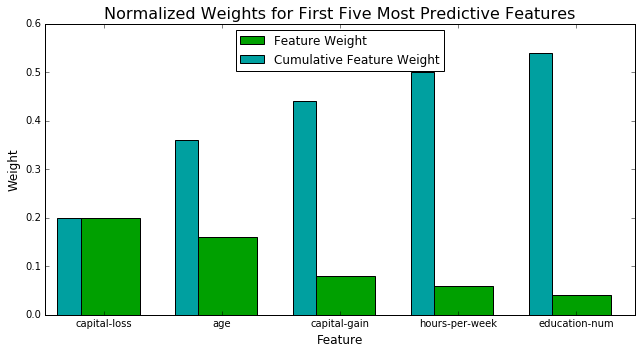

In [14]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier



# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier(random_state=10)
model.fit(X_train,y_train)
# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** 4 of the 5 features I listed were extracted to be the most important. The only feature I had wrong was education instead of education-num. The difference between these two features is that education is categorical, while education-num is a numerical (continuous) feature. I think education-num may be more important in the AdaBoostClassifier used during feature extraction due to its weak learner being a decision tree. Since decision trees have to deal with continuous data by asking questions more about ranges of numbers it can maybe split better on the data, rather than individual splits based on the many one hot encoded variables for the different education categories. 

It seems that my ranks were however in the wrong order. Clearly my simple split of features directly impacting income vs those indirectly impacting salary was not a good enough explanation to rank importance. This can be due to the innate complex nature of the workforce which could be impacted things such as regulations. For capital/loss and gain my naive assumption of equal impact on impact was not correct. Maybe having a capital loss has a broader impact on work and lifestyle making it a better predictor for this classification problem.  

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()

trfit = end - start

start = time()
# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

end = time()
trpredict = end-start
# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))

print "Training time on fitting reduced data: {:.4f}".format(trfit)
print "Training time on predicting reduced data: {:.4f}".format(trpredict)


print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8606
Training time on fitting reduced data: 1.3681
Training time on predicting reduced data: 0.0965
F-score on testing data: 0.7316

Final Model trained on reduced data
------
Accuracy on testing data: 0.8325
F-score on testing data: 0.6752


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**The F-score and accurcy both decreased by 3.27%, and 7.71% respectively. compared to the full optimized model Decreases are expected since the 5 features account for around 55% of the full feature weights, and if the other features are meaningful this should result in worse predictive performance. However the small percent differences could hint at a couple of things described below:

1) Other features have minimal indivdual impact to the classification due to their small feature weight.
2) Other features may have some collinearity and in some cases are canceling out there impact on the overall classification.

Training Time for the reduced classifier was 1.3681 seconds which was less than the ~1.8 seconds when training the unoptimized model. This was a percent decrease of around 24% and around 0.43 seconds. On this particular training set I would still use the full feature set even if training time was a factor. 

This is because 2 seconds is still suitable for real life where it would not be the bottleneck in getting things done (especially if any necessary hardware was already configured for training/running an algorithm). Predicting time was similar (slightly less, but unoptimized training time also included predicting first 300 traiing examples). In addition the 13 original features are things I would expect a charity could obtain about potential donors (may already have this if they have some sort of membership system). Thus reducing the features would not eliminate much complexity in data collection. In addition due to a non-profit having limited resources I think the added training time for the full feature set would be worth the value for the increases in accuracy and F-score. I would however recommend doing a more sophisticated K-Fold cross validation to get more representative performance metrics. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.